# Modelando os preços do Airbnb 
Vamos modelar os preços dos apartamentos do Airbnb no Rio de Janeiro. Em outras palavras, o objetivo é criar nosso próprio modelo de sugestão de preço. Usaremos dados de http://insideairbnb.com/ que coletamos em março de 2019. Este trabalho foi inspirado no pedido da cognitivo de modelagem para cientista de dados.


## Pré-processamento de Dados 

In [1]:
import random
random.seed(42)

Em seguida, importamos as listagens reunidas no arquivo csv.

In [2]:
import pandas as pd

listings_file_path = 'listings.csv.gz' 
listings = pd.read_csv(listings_file_path, compression="gzip", low_memory=False)
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

Os dados têm 106 colunas ou recursos. Nosso primeiro passo é realizar a seleção de recursos para reduzir esse número.

### Seleção de variáveis
Para alguns dos recursos, já é óbvio que eles não terão qualquer utilidade apenas olhando o nome deles; portanto, nós os removemos.

In [3]:
useless = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'city', 'state', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'weekly_price', 'monthly_price']
listings.drop(useless, axis=1, inplace=True)

Também podemos excluir os seguintes recursos, pois eles estão disponíveis apenas para apartamentos antigos do Airbnb. Vamos imaginar que somos novos no Airbnb e queremos alugar um apartamento. Nesse momento, não teremos nenhuma pontuação de revisão para um apartamento, portanto, devemos remover todos os recursos relacionados a isso.

In [4]:
listings.drop(listings.filter(regex = 'review').columns, axis = 1, inplace = True)
listings.columns

Index(['host_total_listings_count', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'requires_license', 'license', 'jurisdiction_names', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_li

#### Seleção em dados ausentes 
Os recursos que possuem um número alto de valores ausentes não são úteis para o nosso modelo, portanto, devemos removê-los.

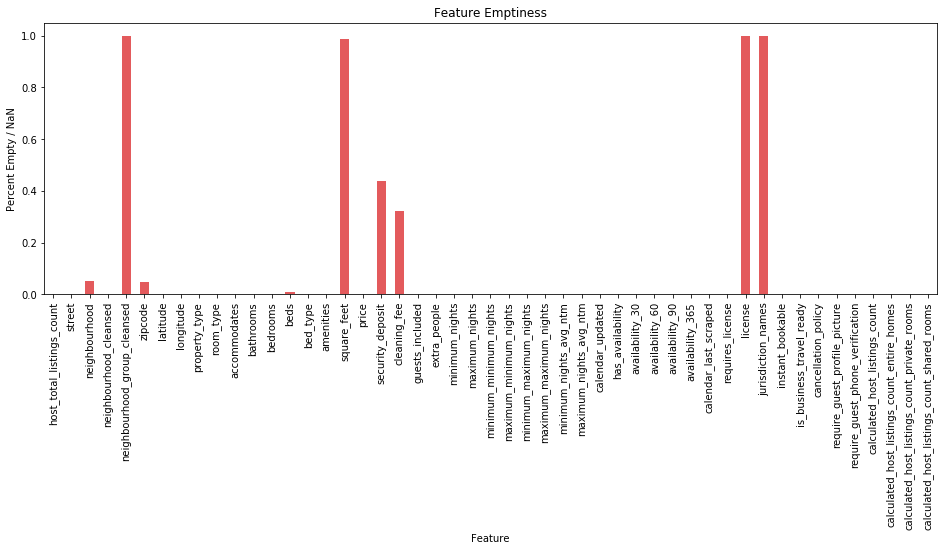

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

percentage_missing_data = listings.isnull().sum() / listings.shape[0]
ax = percentage_missing_data.plot(kind = 'bar', color='#E35A5C', figsize = (16, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('Percent Empty / NaN')
ax.set_title('Feature Emptiness')
plt.show()

Como podemos ver, as características `neighbourhood_group_cleansed`, `square_feet`, `has_availability`, `license` e `jurisdiction_names` na sua maioria têm valores ausentes. Os recursos `neighbourhood`, `cleaning_fee` e `security_deposit` mais de 30% vazios, o que é muito na minha opinião. O `zipcode` também possui alguns valores ausentes, mas podemos removê-los ou imputá-los com precisão razoável.

In [6]:
useless = ['neighbourhood', 'neighbourhood_group_cleansed', 'square_feet', 'security_deposit', 'cleaning_fee', 
           'has_availability', 'license', 'jurisdiction_names']
listings.drop(useless, axis=1, inplace=True)

#### Seleção em recursos categóricos esparsos 
Vamos dar uma olhada nos dados categóricos para ver o número de valores exclusivos.

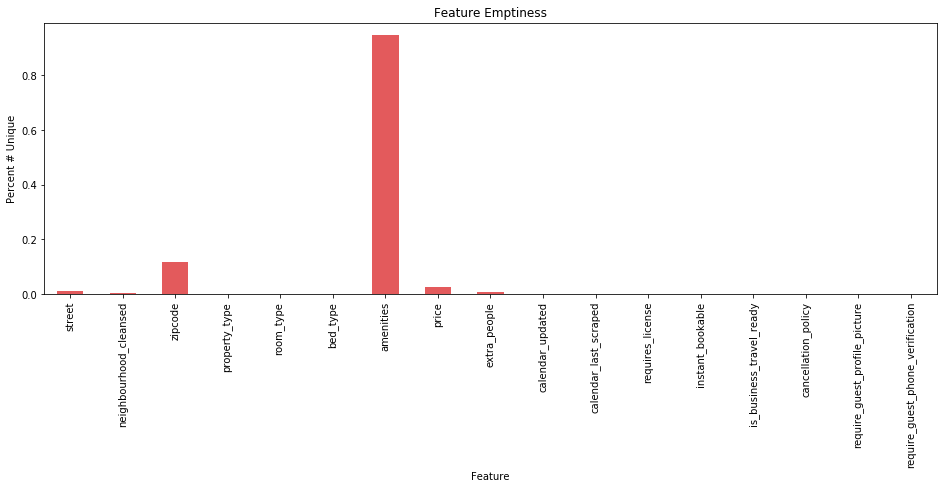

In [7]:
categories = listings.columns[listings.dtypes == 'object']
percentage_unique = listings[categories].nunique() / listings.shape[0]

ax = percentage_unique.plot(kind = 'bar', color='#E35A5C', figsize = (16, 5))
ax.set_xlabel('Feature')
ax.set_ylabel('Percent # Unique')
ax.set_title('Feature Emptiness')
plt.show()

Podemos ver que os recursos  `street` and `amenities` tem um grande número de valores exclusivos. Seria necessário algum processamento de linguagem natural para agrupá-los adequadamente em recursos úteis. Acreditamos que temos informações de localização suficientes  `neighbourhood_cleansed` and `zipcode` isso, removeremos `street`. Nós também remover  `amenities`, `calendar_updated` and `calendar_last_updated` variáveis como estas são muito complicadas processo para o momento.

In [8]:
to_drop = ['street', 'amenities', 'calendar_last_scraped', 'calendar_updated']
listings.drop(to_drop, axis=1, inplace=True)

Agora, vamos dar uma olhada no variável `zipcode`. A visualização acima mostra que existem muitos códigos postais diferentes, talvez muitos?

In [9]:
print("Número de códigos postais:", listings['zipcode'].nunique())

Número de códigos postais: 4248


De fato, existem muitos códigos postais. Se deixarmos essa variável como está, isso poderá causar super ajuste. Em vez disso, podemos reagrupar os códigos postais. No momento, eles estão separados como no exemplo a seguir: RJ 1PE. Manteremos a primeira parte do código postal (por exemplo, RJ) e aceitaremos que isso nos fornece algumas informações de localização menos precisas.

In [10]:
listings['zipcode'] = listings['zipcode'].str.slice(0,3)
listings['zipcode'] = listings['zipcode'].fillna("OTHER")
print("Número de códigos postais:", listings['zipcode'].nunique())

Número de códigos postais: 78


Agora, só tenho 78 códigos postais diferentes, o que é muito melhor do que antes. Vamos dar uma olhada no dataframe de dados para garantir que os códigos postais tenham o formato correto.

In [11]:
listings.head()

,host_total_listings_count,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2.0,Copacabana,220,-22.96592,-43.17896,Condominium,Entire home/apt,5,1.0,2.0,...,f,t,f,strict_14_with_grace_period,f,f,1,1,0,0
1,0.0,Ipanema,224,-22.98467,-43.19611,Apartment,Entire home/apt,6,2.0,2.0,...,f,f,f,strict_14_with_grace_period,f,f,1,1,0,0
2,3.0,Copacabana,220,-22.97712,-43.19045,Apartment,Entire home/apt,2,1.0,1.0,...,f,f,f,strict_14_with_grace_period,t,t,3,3,0,0
3,1.0,Ipanema,224,-22.98302,-43.21427,Apartment,Entire home/apt,3,1.0,1.0,...,f,t,f,strict_14_with_grace_period,f,f,1,1,0,0
4,1.0,Ipanema,220,-22.98816,-43.19359,Apartment,Entire home/apt,2,1.5,1.0,...,f,f,f,strict_14_with_grace_period,t,t,1,1,0,0


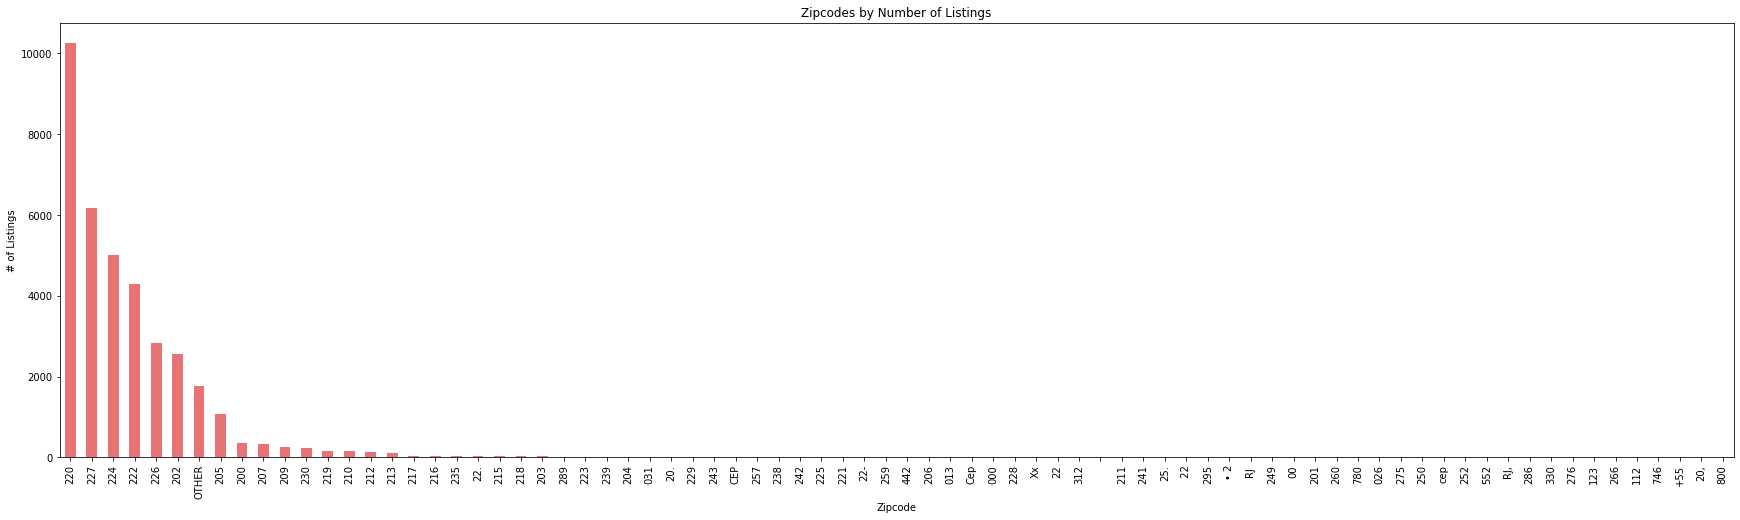

In [12]:
count_per_zipcode = listings['zipcode'].value_counts()
ax = count_per_zipcode.plot(kind='bar', figsize = (30,8), color = '#E35A5C', alpha = 0.85)
ax.set_title("Zipcodes by Number of Listings")
ax.set_xlabel("Zipcode")
ax.set_ylabel("# of Listings")
plt.show()

Como podemos ver, muitos códigos postais contêm menos de 200 apartamentos e alguns códigos postais contêm a maioria dos apartamentos. Vamos ficar com esses.

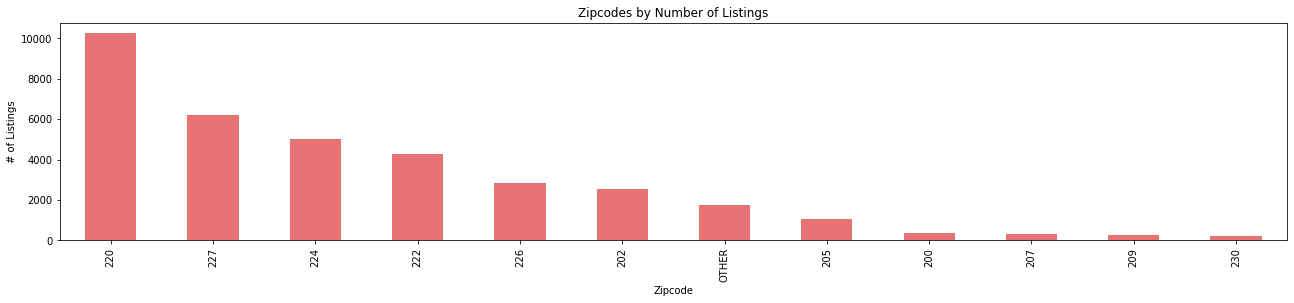

Número de entradas removidas:  924


In [13]:
relevant_zipcodes = count_per_zipcode[count_per_zipcode > 200].index
listings_zip_filtered = listings[listings['zipcode'].isin(relevant_zipcodes)]

# Traçar nova distribuição de códigos postais
count_per_zipcode = listings_zip_filtered['zipcode'].value_counts()
ax = count_per_zipcode.plot(kind='bar', figsize = (22,4), color = '#E35A5C', alpha = 0.85)
ax.set_title("Zipcodes by Number of Listings")
ax.set_xlabel("Zipcode")
ax.set_ylabel("# of Listings")

plt.show()

print('Número de entradas removidas: ', listings.shape[0] - listings_zip_filtered.shape[0])

Essa distribuição é muito melhor e removemos apenas 924 linhas do nosso dataframe, temos ainda 35161 linhas.

Agora vamos dar uma olhada na distribuição do arquivo `neighbourhood_cleansed feature`.

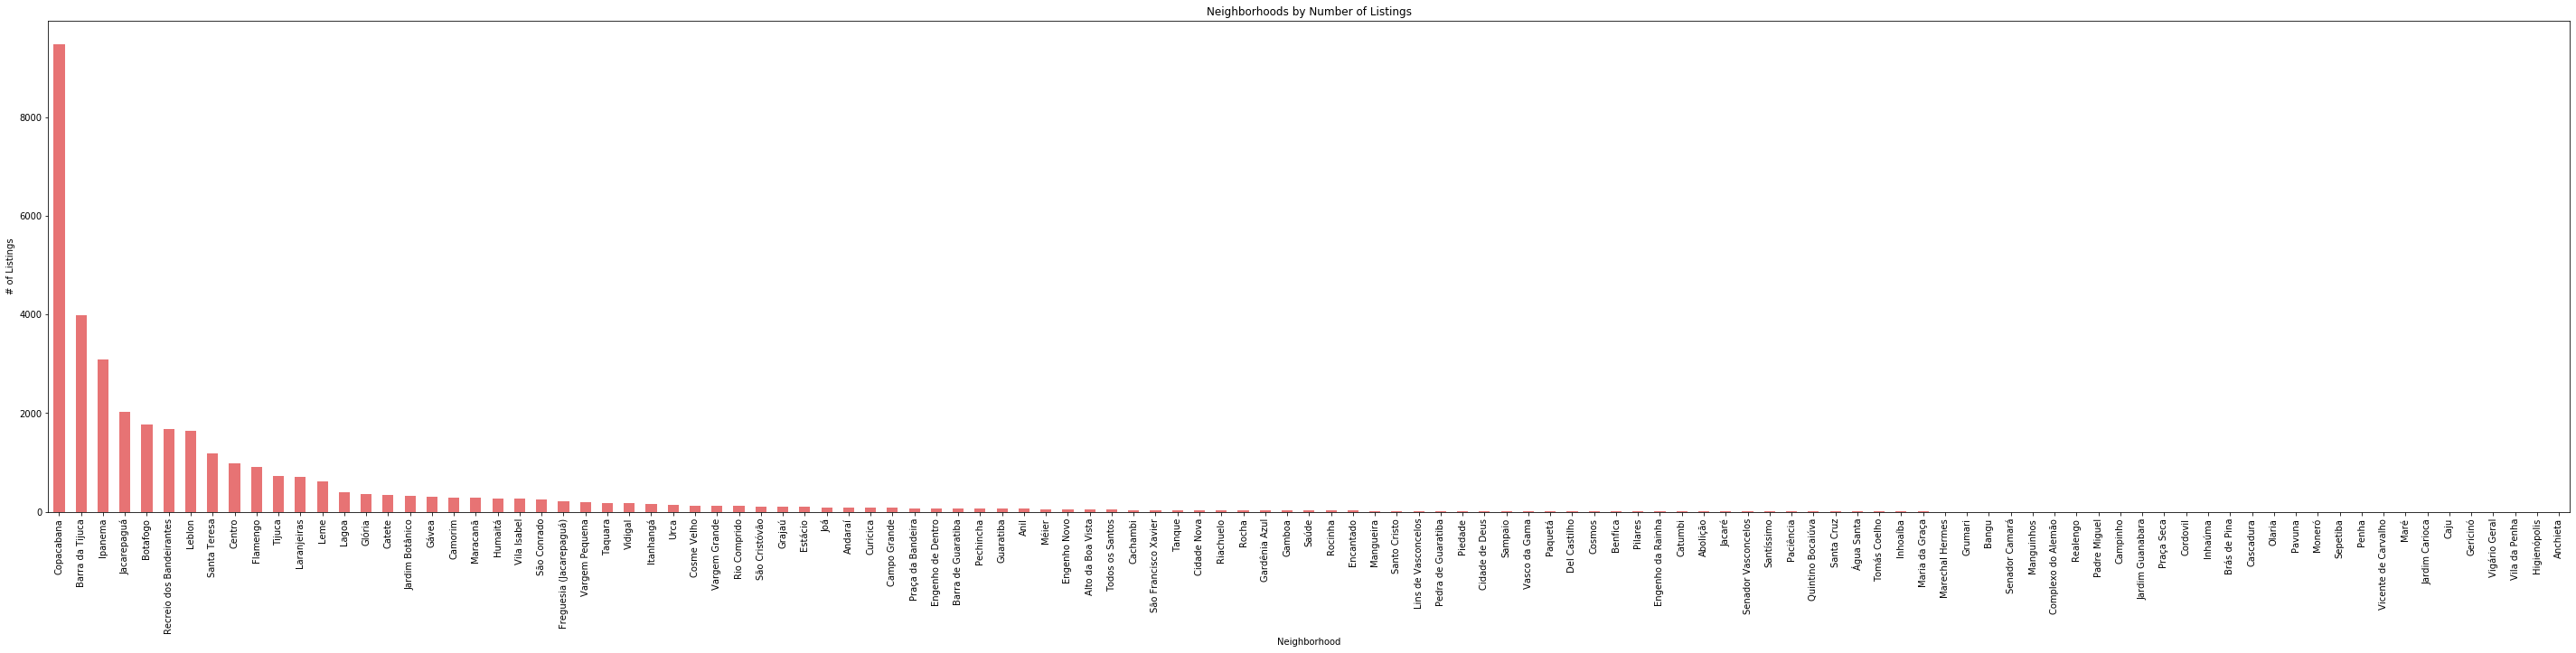

Número de Bairros: 115


In [14]:
# Concentre-se no bairro limpo

# Obter número de listagens em bairros
count_per_neighborhood = listings_zip_filtered['neighbourhood_cleansed'].value_counts()

# Plote o número de listagens em cada bairro
ax = count_per_neighborhood.plot(kind='bar', figsize = (50,10), color = '#E35A5C', alpha = 0.85)
ax.set_title("Neighborhoods by Number of Listings")
ax.set_xlabel("Neighborhood")
ax.set_ylabel("# of Listings")
plt.show()

print("Número de Bairros:", len(count_per_neighborhood))

A distribuição é boa e existem apenas 115 bairros. Mas alguns contêm apenas cerca de 10 apartamentos e isso é inútil para o nosso modelo, então vamos manter os bairros que contêm mais de 100 apartamentos.

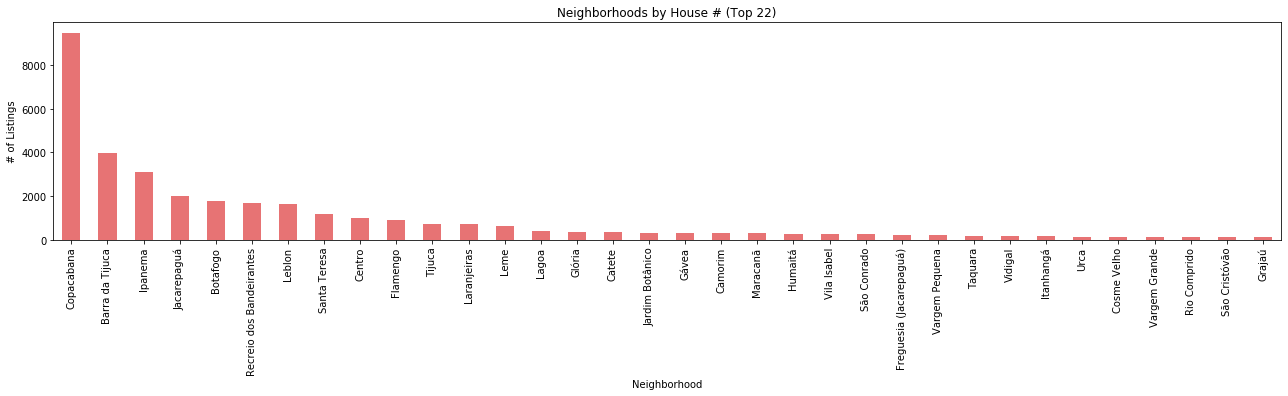

Número de entradas removidas:  1637


In [15]:
relevant_neighborhoods = count_per_neighborhood[count_per_neighborhood > 100].index
listings_neighborhood_filtered = listings_zip_filtered[listings_zip_filtered['neighbourhood_cleansed'].isin(relevant_neighborhoods)]

# Traçar a distribuição de novos bairros
count_per_neighborhood = listings_neighborhood_filtered['neighbourhood_cleansed'].value_counts()
ax = count_per_neighborhood.plot(kind='bar', figsize = (22,4), color = '#E35A5C', alpha = 0.85)
ax.set_title("Neighborhoods by House # (Top 22)")
ax.set_xlabel("Neighborhood")
ax.set_ylabel("# of Listings")

plt.show()

print('Número de entradas removidas: ', listings_zip_filtered.shape[0] - listings_neighborhood_filtered.shape[0])

Ao fazer isso, removemos apenas 1637 linhas. Ainda temos mais de 33524 linhas em nossos dados.

O próximo passo é examinar a multicolinearidade.

#### Seleção de variáveis correlacionados

In [16]:
import numpy as np
from sklearn import preprocessing

# Função para rotular codificar variáveis categóricas.
# Entrada: matriz (matriz de valores)
# Saída: matriz (matriz de valores codificados)
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array
    
# Dataframe Temporário
temp_data = listings_neighborhood_filtered.copy()

# Excluir entradas adicionais com valores NaN
temp_data = temp_data.dropna(axis=0)

# Codificar dados categóricos
temp_data = temp_data.apply(encode_categorical)
# Matriz de computação dos coeficientes de correlação
corr_matrix = temp_data.corr()

corr_matrix

,host_total_listings_count,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
host_total_listings_count,1.000000,-0.025198,-0.016971,-0.052880,0.088121,-0.008120,-0.092745,0.141848,0.053822,0.096773,...,NaN,-0.001345,NaN,0.155332,0.041554,0.014748,0.805938,0.811693,0.259357,-0.000555
neighbourhood_cleansed,-0.025198,1.000000,-0.077592,0.190435,-0.164751,0.118289,0.118244,-0.003739,0.029758,0.056789,...,NaN,-0.012743,NaN,-0.072044,-0.001405,-0.002244,-0.046231,-0.055431,0.028860,0.053366
zipcode,-0.016971,-0.077592,1.000000,-0.611115,-0.610991,0.071064,-0.069579,0.105012,0.128755,0.169780,...,NaN,0.003541,NaN,-0.029831,-0.032011,-0.033089,-0.015123,-0.011001,-0.022910,0.000053
latitude,-0.052880,0.190435,-0.611115,1.000000,0.527044,-0.014561,0.149483,-0.157888,-0.140397,-0.176315,...,NaN,-0.005290,NaN,-0.079118,-0.004930,-0.004508,-0.085853,-0.095046,0.024961,0.012873
longitude,0.088121,-0.164751,-0.610991,0.527044,1.000000,-0.177547,0.002123,-0.118353,-0.140137,-0.191436,...,NaN,-0.038220,NaN,0.133223,0.054488,0.056128,0.112800,0.113641,0.019704,-0.013921
property_type,-0.008120,0.118289,0.071064,-0.014561,-0.177547,1.000000,0.131506,0.035475,0.066404,0.007323,...,NaN,0.067259,NaN,-0.016288,-0.005885,-0.008226,0.022009,-0.012266,0.106092,0.108320
room_type,-0.092745,0.118244,-0.069579,0.149483,0.002123,0.131506,1.000000,-0.425516,-0.143592,-0.311679,...,NaN,0.021185,NaN,-0.130681,0.006555,0.006880,-0.097357,-0.200463,0.450695,0.278523
accommodates,0.141848,-0.003739,0.105012,-0.157888,-0.118353,0.035475,-0.425516,1.000000,0.424064,0.714070,...,NaN,-0.039024,NaN,0.101223,-0.008529,-0.005569,0.136797,0.170558,-0.166221,0.013647
bathrooms,0.053822,0.029758,0.128755,-0.140397,-0.140137,0.066404,-0.143592,0.424064,1.000000,0.509292,...,NaN,-0.043789,NaN,0.036347,-0.007022,-0.006842,0.043963,0.057017,-0.056600,-0.010881
bedrooms,0.096773,0.056789,0.169780,-0.176315,-0.191436,0.007323,-0.311679,0.714070,0.509292,1.000000,...,NaN,-0.074738,NaN,0.050954,-0.002291,-0.001522,0.078226,0.109151,-0.110506,-0.066529


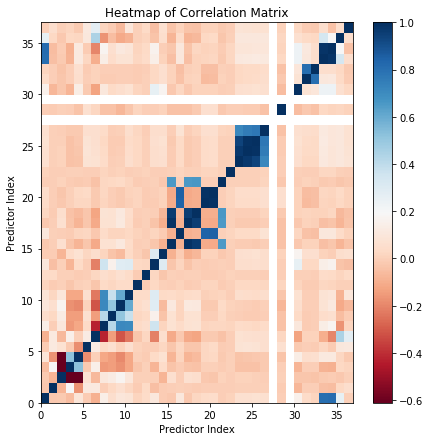

In [17]:
# Exibir mapa de calor 
plt.figure(figsize=(7, 7))
plt.pcolor(corr_matrix, cmap='RdBu')
plt.xlabel('Predictor Index')
plt.ylabel('Predictor Index')
plt.title('Heatmap of Correlation Matrix')
plt.colorbar()

plt.show()

Isso revela que `calculated_host_listings_count_entire_homes` e `calculated_host_listings_count` está altamente correlacionado com, `host_total_listings_count`  portanto, manteremos o último. Também vemos que as `availability_*` variáveis estão correlacionadas entre si. Manteremos `availability_365` como este está menos correlacionado com outras variáveis. Finalmente, decidimos descartar o `requires_license` e `is_business_travel_ready` que tem um resultado de correlação ímpar de NAs que não será útil em nosso modelo.

In [18]:
useless = ['calculated_host_listings_count_entire_homes', 'calculated_host_listings_count', 'availability_30', 'availability_60', 'availability_90', 'requires_license', 'is_business_travel_ready']
listings_processed = listings_neighborhood_filtered.drop(useless, axis=1)

### Manipulação de valores de preço 
Agora, precisamos manipular alguns recursos relacionados à `price` formatação de preço: eles contêm o separador de milhar (',') e o símbolo '$'. Vamos nos livrar dele e transformar essa variável em valores numéricos.

In [19]:
listings_processed = listings_processed.copy()
listings_processed['price'] = listings_processed['price'].str.replace('\$|,', '')
listings_processed['price'] = pd.to_numeric(listings_processed['price'])

listings_processed['extra_people'] = listings_processed['extra_people'].str.replace('\$|,', '')
listings_processed['extra_people'] = pd.to_numeric(listings_processed['extra_people'])

### Uma codificação quente para variáveis categóricas 
As variáveis categóricas precisam ser Um codificado a quente para serem convertidas em vários recursos numéricos e usadas em um modelo de Machine Learning. Este método é muito bem explicado neste bloco de notas Kaggle: https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding.

In [20]:
# Uma codificação a quente para variáveis categóricas
listings_processed = pd.get_dummies(listings_processed)
listings_processed.shape

(33524, 122)

### Divisão de dados: Variáveis / etiquetas - Conjunto de treinamento / conjunto de testes 
Agora nos dividimos em variáveis e etiquetas e conjuntos de treinamento e teste. Também convertemos o trem e testamos o quadro de dados em matrizes numpy para que possam ser usadas para treinar e testar os modelos.

In [21]:
# Embaralhe os dados para garantir uma boa distribuição para os conjuntos de treinamento e teste
from sklearn.utils import shuffle
listings_processed = shuffle(listings_processed)

# Extrair recursos e etiquetas
y = listings_processed['price']
X = listings_processed.drop('price', axis = 1)

# Conjuntos de treinamento e teste
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

train_X = np.array(train_X)
test_X = np.array(test_X)
train_y = np.array(train_y)
test_y = np.array(test_y)

train_X.shape, test_X.shape

((25143, 121), (8381, 121))

## Modelagem

Agora que o pré-processamento de dados terminou, posso começar a segunda parte deste trabalho: aplicar diferentes modelos de Machine Learning. Decidimos aplicar 3 modelos diferentes:

* Floresta aleatória, com o RandomForestRegressor da biblioteca Scikit-learn
* Método de aumento de gradiente, com o XGBRegressor da biblioteca XGBoost
* Rede Neural, com o MLPRegressor da biblioteca Scikit-learn.

Cada vez, aplicamos o modelo com seus hiperparâmetros padrão e, em seguida, ajustamos o modelo para obter os melhores hiperparâmetros. As métricas que usamos para avaliar os modelos são o erro absoluto médio devido à presença de valores extremos e distorção extremos no conjunto de dados.

### Aplicação do regressor aleatório de floresta

Vamos começar com o modelo Random Forest.

#### Com hiperparâmetros padrão
##### Criação do pipeline

Primeiro, criamos um pipeline que imputa os valores ausentes, depois dimensiona os dados e, finalmente, aplica o modelo. Em seguida, ajustamos esse pipeline ao conjunto de treinamento.

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Crie o pipeline (SimpleImputer + scaler + regressor)
my_pipeline_RF = make_pipeline(SimpleImputer(), StandardScaler(),
                               RandomForestRegressor(random_state=42))

# Ajuste o modelo
my_pipeline_RF.fit(train_X, train_y)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n

##### Avaliação do modelo

Avaliamos esse modelo no conjunto de testes, usando o erro absoluto médio para medir o desempenho do modelo. Também incluiremos o erro quadrático médio quadrado (RMSE) para fins de integridade. Como faremos isso repetidamente, é uma boa prática criar uma função.

In [23]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

def evaluate_model(model, predict_set, evaluate_set):
    predictions = model.predict(predict_set)
    print("Median Absolute Error: " + str(round(median_absolute_error(predictions, evaluate_set), 2))) 
    RMSE = round(sqrt(mean_squared_error(predictions, evaluate_set)), 2)
    print("RMSE: " + str(RMSE)) 

In [24]:
evaluate_model(my_pipeline_RF, test_X, test_y)

Median Absolute Error: 148.43
RMSE: 1690.56


Também avaliamos o modelo no conjunto de treinamento, para garantir que evitamos o overfitting.

In [25]:
evaluate_model(my_pipeline_RF, train_X, train_y)

Median Absolute Error: 52.97
RMSE: 621.89


Esses primeiros resultados são muito bons. Para ter certeza de que fizemos uma boa seleção de recursos, podemos dar uma olhada nas importâncias dos recursos.

In [26]:
importances = my_pipeline_RF.steps[2][1].feature_importances_
feature_importances = pd.DataFrame({"feature":X.columns.values, "importance":importances})
feature_importances.sort_values("importance", ascending=False).head(22)

,feature,importance
4,bathrooms,0.175778
2,longitude,0.109678
1,latitude,0.088973
8,extra_people,0.050014
6,beds,0.045449
5,bedrooms,0.042446
17,availability_365,0.041954
3,accommodates,0.035087
0,host_total_listings_count,0.033602
12,maximum_minimum_nights,0.032552


In [27]:
# Importâncias cumulativas
feature_importances.importance.sum()

1.0

#### Ajuste de hiperparâmetros 

Tivemos bons resultados com os hiperparâmetros padrão do regressor Random Forest. Mas podemos melhorar os resultados com alguns ajustes no hiperparâmetro. Existem dois métodos principais disponíveis para isso:

* Random search
* Grid search

Você precisa fornecer uma grade de parâmetros para esses métodos. Em seguida, os dois tentam diferentes combinações de parâmetros na grade que você forneceu. Mas o primeiro tenta apenas várias combinações, enquanto o segundo tenta todas as combinações possíveis com a grade que você forneceu.

O que fizemos é que começamos com uma pesquisa aleatória para avaliar aproximadamente uma boa combinação de parâmetros. Feito isso, usamos a pesquisa em grade para obter resultados mais precisos.

In [28]:
from pprint import pprint
# Veja os parâmetros usados pela nossa floresta atual
print('Parametros usados atualmente:\n')
pprint(my_pipeline_RF.get_params())

Parametros usados atualmente:

{'memory': None,
 'randomforestregressor': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False),
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__criterion': 'mse',
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_samples': None,
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__min_impurity_split': None,
 'randomfor

##### Pesquisa aleatória com validação cruzada

In [29]:
import numpy as np

# Número de árvores na floresta aleatória
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 11)]
# Número de recursos a serem considerados em cada divisão
max_features = ['auto', 'sqrt']
# Número máximo de níveis na árvore
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Número mínimo de amostras necessárias para dividir um nó
min_samples_split = [2, 5, 10]
# Número mínimo de amostras necessárias em cada nó da folha
min_samples_leaf = [1, 2, 4]
# Método de seleção de amostras para treinar cada árvore
bootstrap = [True, False]
# Criando um random grid
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
               'randomforestregressor__min_samples_split': min_samples_split,
               'randomforestregressor__min_samples_leaf': min_samples_leaf,
               'randomforestregressor__bootstrap': bootstrap}

In [ ]:
# Use um random grid para procurar os melhores hyperparâmetros
from sklearn.model_selection import RandomizedSearchCV

# Random search de parâmetros, usando Validação cruzada de 2 vezes, 
# pesquise em 100 combinações diferentes e use todos os núcleos disponíveis
rf_random = RandomizedSearchCV(estimator = my_pipeline_RF, 
                               param_distributions = random_grid, 
                               n_iter = 50, cv = 2, verbose=2,
                               random_state = 42, n_jobs = -1, 
                               scoring = 'neg_median_absolute_error')
# Encaixando no nosso modelo
rf_random.fit(train_X, train_y)

rf_random.best_params_

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/vinho/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 19.4min


##### Pesquisa em grade com validação cruzada 

In [ ]:
from sklearn.model_selection import GridSearchCV
# Criando a grade de parâmetros com base nos resultados da pesquisa aleatória
param_grid = {
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__max_depth': [30, 35, 40], 
    'randomforestregressor__max_features': ['auto'],
    'randomforestregressor__min_samples_leaf': [2],
    'randomforestregressor__min_samples_split': [4, 5, 6],
    'randomforestregressor__n_estimators': [950, 1000, 1050] 
}

# Instanciando o modelo de pesquisa em grade
grid_search = GridSearchCV(estimator = my_pipeline_RF, 
                           param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2, 
                           scoring = 'neg_median_absolute_error')

# Ajustar a pesquisa da grade aos dados
grid_search.fit(train_X, train_y)

grid_search.best_params_

##### Modelo  Final

In [ ]:
# Criando o pipeline (SimpleImputer + scaler + regressor)
my_pipeline_RF_grid = make_pipeline(SimpleImputer(), StandardScaler(),
                                      RandomForestRegressor(random_state=42,
                                                            bootstrap = True,
                                                            max_depth = 30,
                                                            max_features = 'auto',
                                                            min_samples_leaf = 2,
                                                            min_samples_split = 4,
                                                            n_estimators = 1050))

# Ajustar o modelo
my_pipeline_RF_grid.fit(train_X, train_y)

evaluate_model(my_pipeline_RF_grid, test_X, test_y)

Obtemos melhores resultados com o modelo ajustado do que com os hiperparâmetros padrão, mas a melhoria do erro absoluto médio não é surpreendente. Talvez tenhamos uma precisão melhor se usarmos outro modelo.

### Aplicação do Gradient Boosting Regressor

Vamos tentar com o modelo de aumento de gradiente XGBoost. Esse modelo geralmente produz bons resultados nas competições do Kaggle. O primeiro passo é usá-lo com os hiperparâmetros padrão.
#### Com hiperparâmetros padrão 

In [ ]:
from xgboost import XGBRegressor

# Criando o pipeline: SimpleImputation + Scale + MLP regressor
my_pipeline_XGB = make_pipeline(SimpleImputer(), StandardScaler(), 
                                XGBRegressor(random_state = 42))

# Ajustar o modelo
my_pipeline_XGB.fit(train_X, train_y)

evaluate_model(my_pipeline_XGB, test_X, test_y)

No momento, os modelos de Random Forest ajustados e até não ajustados oferecem melhores resultados. Quero ver se o ajuste do hiperparâmetro fará com que este modelo seja melhor que o modelo Random Forest.

#### Ajuste de Hiperparâmetro

In [ ]:
# Veja os parâmetros usados pelo nosso modelo atual
print('Parâmetros atuais sendo usados:\n')
pprint(my_pipeline_XGB.get_params())

#### Grid Search com Cross Validation 

In [ ]:
param_grid = {'xgbregressor__learning_rate': [0.1, 0.05], 
              'xgbregressor__max_depth': [5, 7, 9],
              'xgbregressor__n_estimators': [100, 500, 900]}

# Instanciando o modelo de pesquisa em grade
grid_search = GridSearchCV(estimator = my_pipeline_XGB,
                           param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2, 
                           scoring = 'neg_median_absolute_error')

# Ajustar a pesquisa da grade aos dados
grid_search.fit(train_X, train_y)

grid_search.best_params_

#### Modelo Final

In [ ]:
# Criando o pipeline: SimpleImputation + Scale + MLP regressor
my_pipeline_XGB_grid = make_pipeline(SimpleImputer(), StandardScaler(), 
                                     XGBRegressor(random_state = 42,
                                                  learning_rate = 0.05,
                                                  max_depth = 9,
                                                  n_estimators = 500))

# Ajustar o modelo
my_pipeline_XGB_grid.fit(train_X, train_y)

evaluate_model(my_pipeline_XGB_grid, test_X, test_y)

O modelo XGBoost ajustado oferece melhores resultados do que o modelo não ajustado. Também fornece quase os mesmos resultados que o modelo Random Forest ajustado (MAE: 13.57).

### Aplicação do Multi Layer Perceptron Regressor

Agora vamos tentar uma rede neural, ou, para ser mais preciso, um perceptron multicamada que é uma classe da rede neural. Eu aplico esse regressor com hiperparâmetros padrão, exceto o número máximo de iterações, a fim de deixá-lo rodar até o final.

#### Com hyperparâmetros padrão

In [ ]:
from sklearn.neural_network import MLPRegressor

# Criando o pipeline: SimpleImputation + Scale + Feature Selection + MLP regressor
my_pipeline_NN = make_pipeline(SimpleImputer(), StandardScaler(), 
                               MLPRegressor(random_state = 42,
                                            max_iter = 400))

# Ajustar o modelo
my_pipeline_NN.fit(train_X, train_y)

evaluate_model(my_pipeline_NN, test_X, test_y)

Os resultados não são muito bons em comparação com os dois modelos anteriores. Vamos tentar ajustar essa rede neural, talvez os parâmetros padrão não sejam muito bons para esses dados.

#### Grid Search com Cross Validation 

In [ ]:
# Quais parâmetros do meu pipeline?
my_pipeline_NN.get_params()

In [ ]:
param_grid = {
    'mlpregressor__activation': ['logistic', 'tanh'],
    'mlpregressor__solver': ['sgd', 'adam'],
    'mlpregressor__early_stopping': [True, False],
    'mlpregressor__hidden_layer_sizes': [(100,), (100, 50), (100, 100), (100, 100, 100)],
    'mlpregressor__learning_rate_init': [0.001, 0.0001],
}

grid_search = GridSearchCV(estimator = my_pipeline_NN,
                           param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2,
                           scoring = 'neg_median_absolute_error')

grid_search.fit(train_X, train_y)

grid_search.best_params_

#### Model Final

In [ ]:
# Criando o pipeline: imputation + MLP regressor
my_pipeline_NN_grid = make_pipeline(SimpleImputer(), StandardScaler(),
                                    MLPRegressor(hidden_layer_sizes = (100, 50),
                                                 activation = 'logistic',
                                                 early_stopping = False,
                                                 learning_rate_init = 0.0001,
                                                 solver = 'adam',
                                                 max_iter = 500,
                                                 random_state = 42)) 

# Ajustar o modelo
my_pipeline_NN_grid.fit(train_X, train_y)

evaluate_model(my_pipeline_NN_grid, test_X, test_y)

A Rede Neural sintonizada é muito melhor que a que possui hiperparâmetros padrão. No entanto, ainda é muito menos preciso que os dois primeiros modelos.

### Visualização do desempenho dos modelos

In [ ]:
error_val = pd.DataFrame({'error_val':[14.2, 13.57, 15.94, 13.54, 18.76, 15.23]},
                        index = ['RF','Tuned RF','XGB', 'Tuned XGB', 'MLP', 'Tuned MLP'])
error_val = error_val.sort_values('error_val')
plt.figure(figsize=(10,10))
ax = error_val.error_val.plot(kind='bar', align = 'center', color='#E35A5C')
plt.xticks(rotation=0)
plt.xlabel('Model')
plt.ylabel('Median Absolute Error in $')
plt.title('Median Absolute Error Model Comparison')
plt.show()

O XGBoost e o Random Forest ajustado deram os melhores resultados no conjunto de testes. Surpreendentemente, o Perceptron de várias camadas com parâmetros padrão deu os erros absolutos medianos mais altos e o sintonizado nem deu melhores resultados do que a floresta aleatória padrão. Isso é incomum, talvez o Multi Layer Perceptron precise de mais dados para ter um desempenho melhor ou precise de mais ajustes em hiperparâmetros importantes, como o hidden_layer_sizes.

## Conclusão

Modelamos os preços dos apartamentos do Airbnb usando dados descritivos do site do airbnb. Primeiro, nós pré-processamos os dados para remover quaisquer recursos redundantes e reduzir a esparsidade dos dados. Em seguida, aplicamos três algoritmos diferentes, inicialmente com parâmetros padrão que depois ajustamos. Em nossos resultados, a Floresta Aleatória ajustada e o XGBoost ajustado tiveram o melhor desempenho.

Para melhorar ainda mais nossos modelos, poderíamos incluir mais engenharia de recursos, por exemplo, recursos baseados em tempo. Também poderíamos tentar uma sintonia mais extensa de hiperparâmetros. Se você quiser tirar dúvidas, sobre o código e os dados desta publicação podem ser encontrados no [GitHub](https://github.com/johndelara1)